# Análisis de Datos con Spark: Explorando el Universo Musical de Spotify

# Introducción

En esta tarea, exploraremos un extenso conjunto de datos de canciones de Spotify. Este dataset contiene características de audio detalladas para cientos de miles de canciones, junto con metadatos como artista, año de lanzamiento, popularidad y géneros musicales. A través del análisis de estos datos, podremos descubrir patrones en la evolución de la música a lo largo del tiempo, entender qué hace que algunas canciones sean más populares que otras, y crear sistemas de recomendación basados en características de audio.



# Dataset

## Nombre del Dataset: Spotify Song Attributes Dataset Fuente: 
Kaggle - Spotify Dataset 1921-2020, 600k+ Tracks

Este dataset incluye:

tracks.csv: Contiene información sobre más de 600,000 canciones, con características como:

track_id: Identificador único de la canción
name: Nombre de la canción
popularity: Puntuación de popularidad (0-100)
duration_ms: Duración en milisegundos
explicit: Si la canción tiene contenido explícito
artists: Artistas que participaron en la canción
id_artists: IDs de los artistas
release_date: Fecha de lanzamiento
danceability: Qué tan adecuada es la canción para bailar (0.0-1.0)
energy: Medida de intensidad y actividad (0.0-1.0)
key: Tonalidad de la canción (0-11)
loudness: Volumen general en decibelios (dB)
mode: Modalidad de la canción (mayor o menor)
speechiness: Presencia de palabras habladas (0.0-1.0)
acousticness: Medida de si la canción es acústica (0.0-1.0)
instrumentalness: Predice si una canción no contiene vocales (0.0-1.0)
liveness: Detecta presencia de audiencia (0.0-1.0)
valence: Positividad musical de la canción (0.0-1.0)
tempo: Velocidad o ritmo estimado en BPM
time_signature: Compás estimado
artists.csv: Información sobre los artistas, incluyendo:

id: ID único del artista
followers: Número de seguidores
genres: Géneros asociados con el artista
name: Nombre del artista
popularity: Puntuación de popularidad (0-100)

# Parte 1: Configuración del Entorno y Carga de Datos

## Paso 1: Configurar Spark

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Crear la sesión de Spark con configuración local optimizada
spark = SparkSession.builder \
    .appName("SpotifySparkAssignment") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Ajustar configuraciones adicionales para entorno local
spark.conf.set("spark.sql.shuffle.partitions", "8")
print("Sesión de Spark Creada con éxito!")

Sesión de Spark Creada con éxito!


## Paso 2: Cargar los archivos CSV de tracks y artists

## Cargamos los datasets tracks.csv y artists.csv

In [3]:
# Definir la ruta base de los datos
data_path = "/home/jovyan/work/data/spotify/"

# Cargar tracks.csv en un DataFrame de Spark
tracks_df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(data_path + "tracks.csv")

# Cargar artists.csv en un DataFrame de Spark
artists_df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(data_path + "artists.csv")

print("Data Cargada Exitosamente!")

Data Cargada Exitosamente!


# Paso 3: Revisar el esquema y mostrar primeras filas

In [4]:
# Mostrar el esquema (columnas y tipos) de tracks_df y artists_df
print("Esquema de tracks_df:")
tracks_df.printSchema()
print("\nEsquema de artists_df:")
artists_df.printSchema()

# Mostrar las primeras 5 filas de cada DataFrame
print("\nPrimeras 5 filas de tracks_df:")
tracks_df.show(5, truncate=False)
print("\nPrimeras 5 filas de artists_df:")
artists_df.show(5, truncate=False)

# (Opcional) Contar registros en cada DataFrame
track_count = tracks_df.count()
artist_count = artists_df.count()
print(f"\nTotal de canciones (tracks_df): {track_count}")
print(f"Total de artistas (artists_df): {artist_count}")

Esquema de tracks_df:
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- id_artists: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- time_signature: string (nullable = true)


Esquema de artists_df:
root
 |-- id: string (nullable = true)
 |-- followers: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- name: string (n

# Paso 4: Limpieza y preparación de los datos

In [6]:
# Eliminar filas que tengan NULL en release_date o duration_ms
tracks_df = tracks_df.dropna(subset=["release_date", "duration_ms"])

# Si release_date tiene solo 4 caracteres (AAAA), añadir "-01-01" para formar una fecha completa
tracks_df = tracks_df.withColumn(
    "release_date_fixed",
    F.when(F.length("release_date") == 4, F.concat(F.col("release_date"), F.lit("-01-01")))
     .otherwise(F.col("release_date"))
)

# Convertir release_date_fixed a tipo fecha y extraer el año
tracks_df = tracks_df.withColumn("release_date_fixed", F.to_date("release_date_fixed", "yyyy-MM-dd"))
tracks_df = tracks_df.withColumn("release_year", F.year("release_date_fixed"))

# Crear columna duration_min convirtiendo milisegundos a minutos (redondeado a 2 decimales)
tracks_df = tracks_df.withColumn("duration_min", F.round(F.col("duration_ms") / 60000.0, 2))

# Filtrar por año de lanzamiento razonable y duración positiva
tracks_df = tracks_df.filter(
    (F.col("release_year").between(1920, 2025)) & 
    (F.col("duration_ms") > 0)
)

# Crear el DataFrame final de tracks limpios
tracks_clean = tracks_df.drop("release_date") \
    .withColumnRenamed("release_date_fixed", "release_date")

# Revisar el esquema y algunas filas del DataFrame limpio
print("Esquema de tracks_clean:")
tracks_clean.printSchema()
print("Primeras 5 filas de tracks_clean:")
tracks_clean.show(5, truncate=False)

Esquema de tracks_clean:
root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- id_artists: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- time_signature: string (nullable = true)
 |-- release_date: date (nullable = true)
 |-- release_year: integer (nullable = true)
 |-- duration_min: double (nullable = true)

Primeras 5 filas de tracks_clean:
+----------------------+--------------

# Paso 5: Guardar los datos limpios en formato Parquet

In [7]:
# Guardar tracks_clean como archivo Parquet (se creará un directorio de Parquet)
tracks_clean.write.mode("overwrite").parquet(data_path + "tracks_clean.parquet")
print("Archivo Parquet guardado en /home/jovyan/work/data/spotify/tracks_clean.parquet")

Archivo Parquet guardado en /home/jovyan/work/data/spotify/tracks_clean.parquet


# Paso 6: Estadísticas descriptivas de las características de audio

In [8]:
# Seleccionar columnas de características de audio para análisis
audio_cols = ["danceability", "energy", "loudness", "speechiness", 
              "acousticness", "instrumentalness", "liveness", "valence", "tempo"]

print("Estadísticas descriptivas de características de audio:")
tracks_clean.select(audio_cols).describe().show()

Estadísticas descriptivas de características de audio:
+-------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+
|summary|       danceability|             energy|          loudness|        speechiness|       acousticness|   instrumentalness|          liveness|            valence|             tempo|
+-------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+
|  count|             581260|             581260|            581260|             581260|             581260|             581260|            581260|             581260|            581260|
|   mean| 0.5647308442005304|  0.543682586482467|-10.16973024980216|0.10513623077452135|0.44778156191989277|0.11338287403979273|0.2138189175584078|  0.553689442912121|118.54083997178523|
| stddev|0

# Paso 7: Agregados por década

In [9]:
# Crear columna 'decade' que agrupa el año de lanzamiento por década (ejemplo: 1995 -> 1990)
tracks_clean = tracks_clean.withColumn("decade", (F.floor(F.col("release_year")/10) * 10).cast("int"))

# Agrupar por década y calcular el número de canciones y promedio de características de audio por década
tracks_clean.groupBy("decade").agg(
    F.count("*").alias("tracks_count"),
    F.round(F.avg("danceability"), 3).alias("avg_danceability"),
    F.round(F.avg("energy"), 3).alias("avg_energy"),
    F.round(F.avg("loudness"), 1).alias("avg_loudness"),
    F.round(F.avg("speechiness"), 3).alias("avg_speechiness"),
    F.round(F.avg("acousticness"), 3).alias("avg_acousticness"),
    F.round(F.avg("instrumentalness"), 3).alias("avg_instrumentalness"),
    F.round(F.avg("liveness"), 3).alias("avg_liveness"),
    F.round(F.avg("valence"), 3).alias("avg_valence"),
    F.round(F.avg("tempo"), 1).alias("avg_tempo")
).orderBy("decade").show(truncate=False)

+------+------------+----------------+----------+------------+---------------+----------------+--------------------+------------+-----------+---------+
|decade|tracks_count|avg_danceability|avg_energy|avg_loudness|avg_speechiness|avg_acousticness|avg_instrumentalness|avg_liveness|avg_valence|avg_tempo|
+------+------------+----------------+----------+------------+---------------+----------------+--------------------+------------+-----------+---------+
|1920  |7601        |0.604           |0.281     |-14.8       |0.292          |0.89            |0.326               |0.205       |0.6        |113.1    |
|1930  |12952       |0.552           |0.307     |-13.5       |0.195          |0.869           |0.275               |0.217       |0.573      |112.8    |
|1940  |17772       |0.477           |0.269     |-14.2       |0.1            |0.915           |0.382               |0.214       |0.504      |107.1    |
|1950  |33748       |0.488           |0.303     |-14.3       |0.108          |0.837     

# Bloque 8: Visualización de Distribuciones y Mapa de Calor

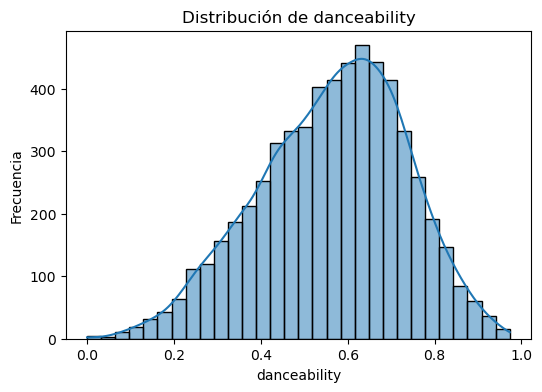

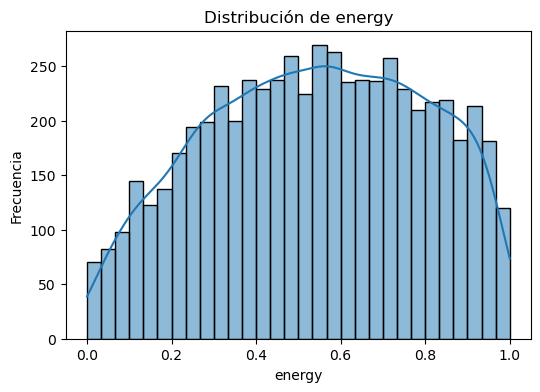

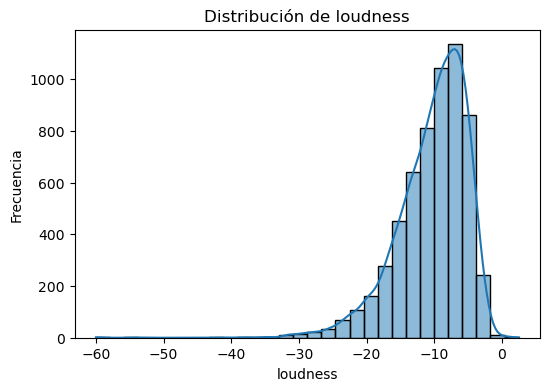

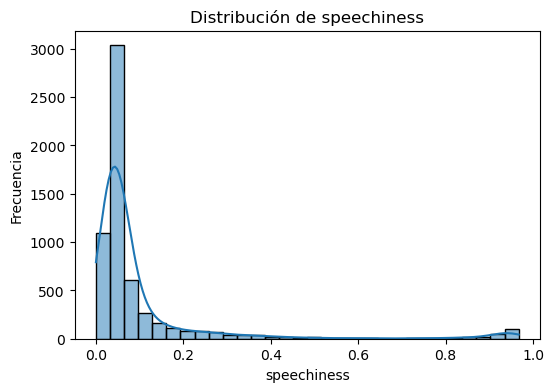

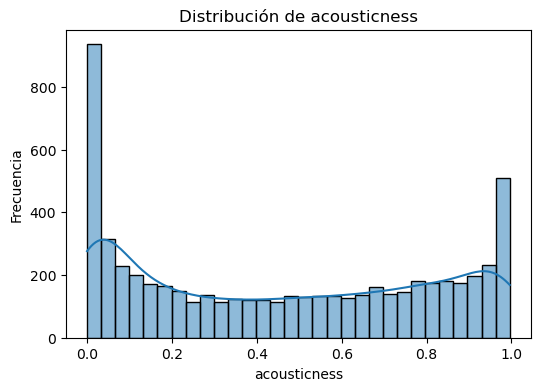

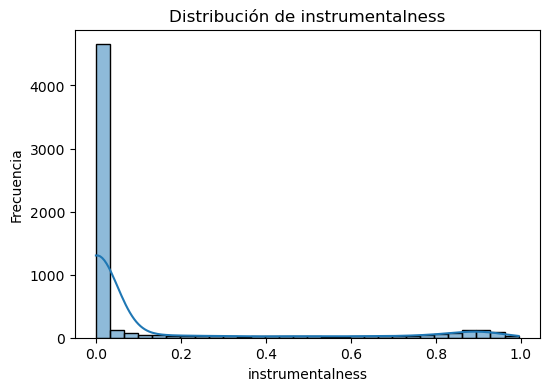

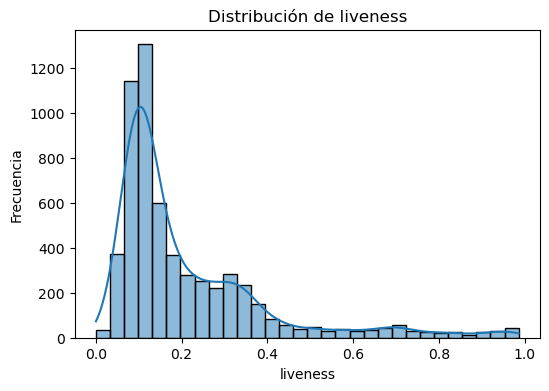

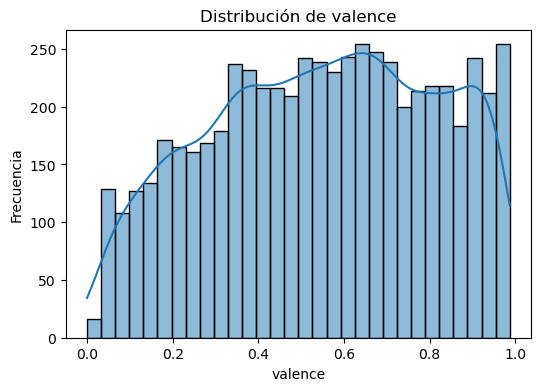

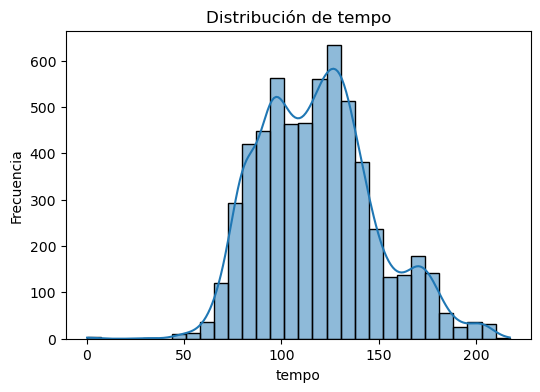

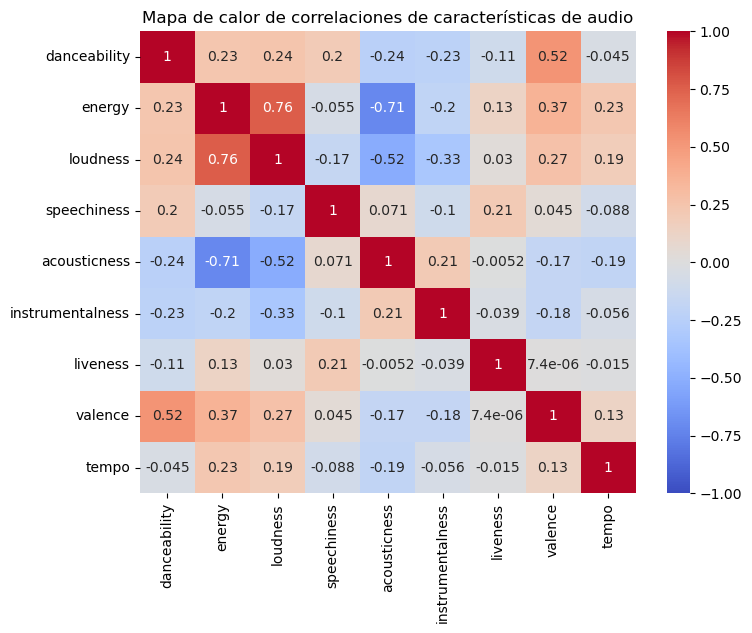

Proceso completado se tardó alrededor de 34 segundos


In [13]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyspark.sql.functions as F

# Iniciar medición de tiempo
start_time = time.time()

# Definir las columnas de características de audio
audio_cols = ["danceability", "energy", "loudness", "speechiness", 
              "acousticness", "instrumentalness", "liveness", "valence", "tempo"]

# Asegurarse de que cada columna de audio esté en tipo double
for col_name in audio_cols:
    tracks_clean = tracks_clean.withColumn(col_name, F.col(col_name).cast("double"))

# Extraer una muestra pequeña para visualización (1% de los datos)
sample_df = tracks_clean.select(audio_cols).sample(fraction=0.01, seed=42).toPandas()

# Generar histogramas para cada característica de audio
for col_name in audio_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(sample_df[col_name], bins=30, kde=True)
    plt.title(f"Distribución de {col_name}")
    plt.xlabel(col_name)
    plt.ylabel("Frecuencia")
    plt.show()

# Calcular la matriz de correlación usando Spark
corr_matrix = []
for col1 in audio_cols:
    row = []
    for col2 in audio_cols:
        corr_val = tracks_clean.stat.corr(col1, col2)
        row.append(corr_val)
    corr_matrix.append(row)

# Convertir la matriz de correlación a un DataFrame de pandas para graficar el mapa de calor
corr_df = pd.DataFrame(corr_matrix, index=audio_cols, columns=audio_cols)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Mapa de calor de correlaciones de características de audio")
plt.show()

# Medir el tiempo de ejecución
elapsed_time = int(time.time() - start_time)
print("Proceso completado se tardó alrededor de %d segundos" % elapsed_time)

# Bloque 9: Análisis de Popularidad

+-------------------+------+
|popularity_category| count|
+-------------------+------+
|               Alta|  7304|
|               Baja|189591|
|              Media| 68207|
|           Muy baja|316158|
+-------------------+------+

+-------------------+----------------+----------+----------------+--------------------+------------+-----------+---------+
|popularity_category|avg_danceability|avg_energy|avg_acousticness|avg_instrumentalness|avg_liveness|avg_valence|avg_tempo|
+-------------------+----------------+----------+----------------+--------------------+------------+-----------+---------+
|               Alta|            0.65|     0.643|           0.246|               0.024|       0.174|       0.52|    121.9|
|               Baja|           0.583|     0.604|           0.348|               0.069|       0.214|       0.56|    120.0|
|              Media|           0.613|     0.634|           0.297|               0.053|        0.19|      0.532|    121.1|
|           Muy baja|        

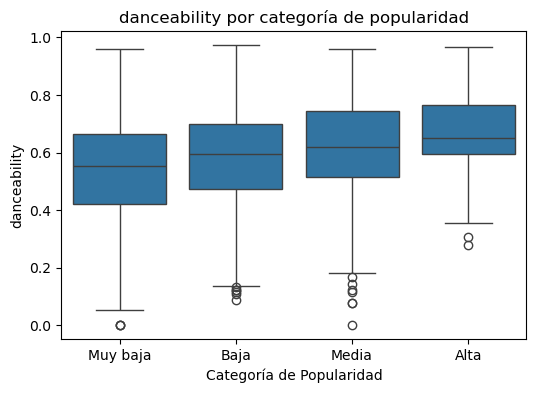

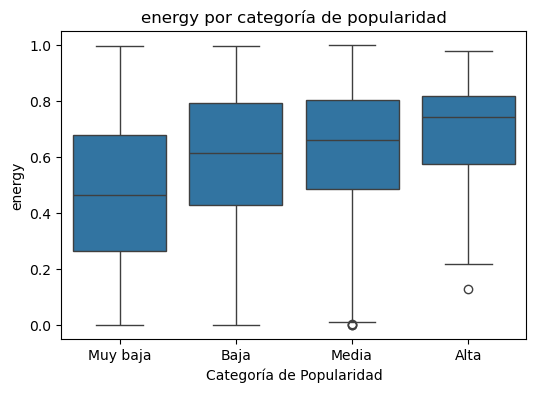

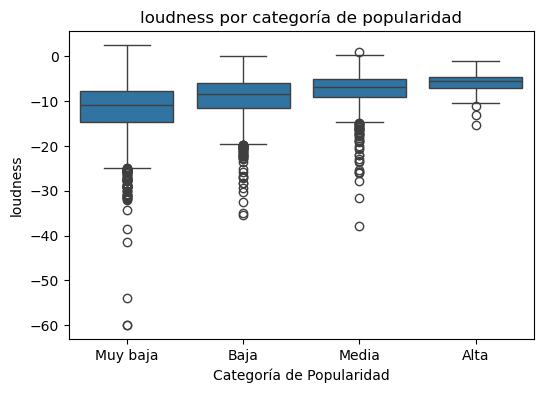

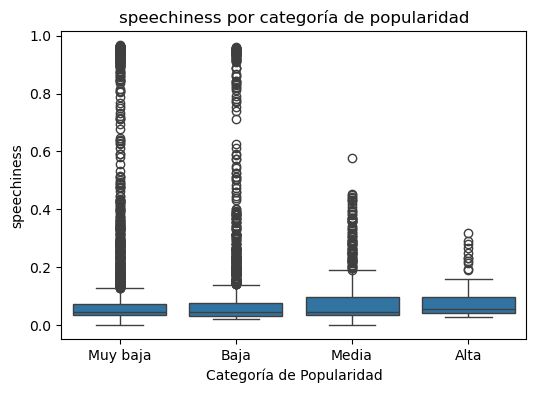

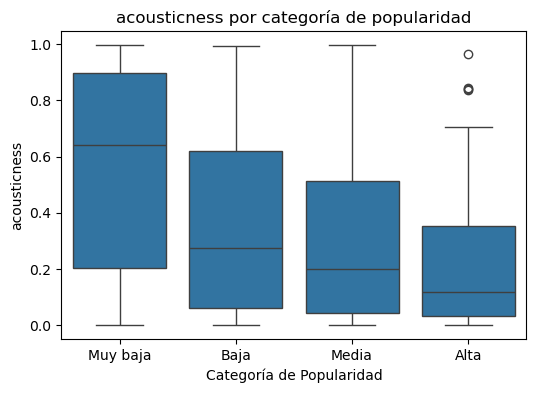

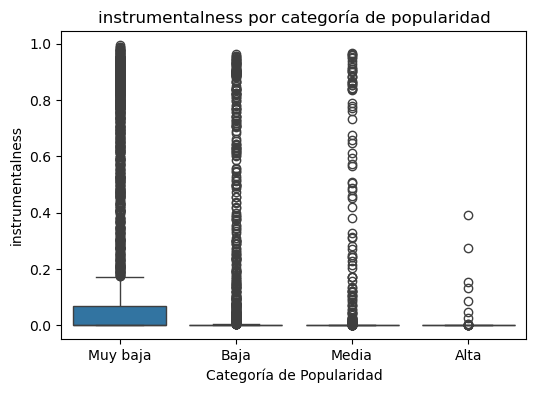

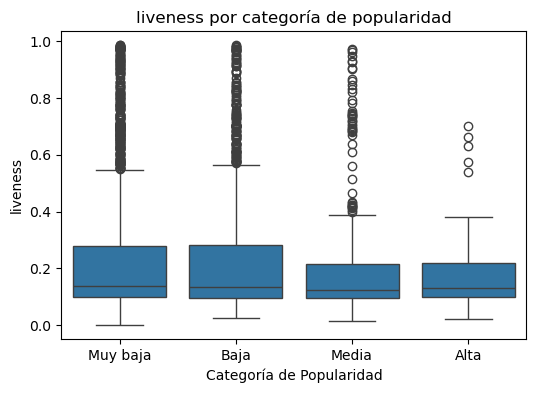

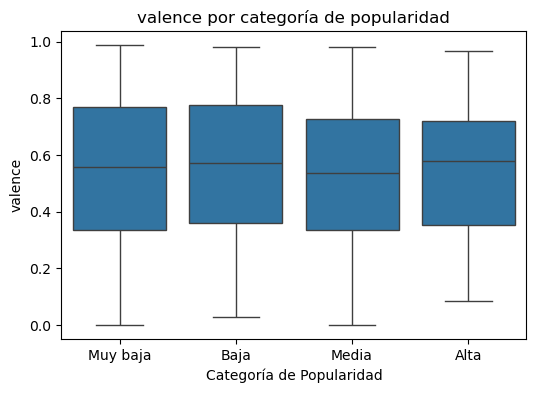

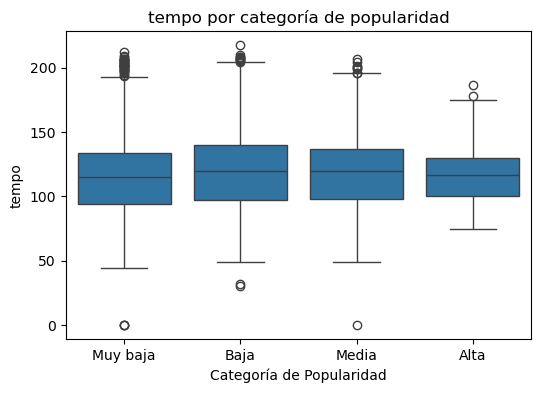

Proceso de análisis de popularidad completado en 5 segundos


In [15]:
import time
start_time = time.time()

# Convertir la columna 'popularity' a entero (si no lo está)
tracks_clean = tracks_clean.withColumn("popularity", F.col("popularity").cast("int"))

# Crear una nueva columna de categoría de popularidad
tracks_clean = tracks_clean.withColumn("popularity_category", 
    F.when(F.col("popularity") >= 70, "Alta")
     .when((F.col("popularity") >= 50) & (F.col("popularity") < 70), "Media")
     .when((F.col("popularity") >= 30) & (F.col("popularity") < 50), "Baja")
     .otherwise("Muy baja")
)

# Mostrar el conteo de canciones por categoría
tracks_clean.groupBy("popularity_category").count().orderBy("popularity_category").show()

# Calcular estadísticas descriptivas de audio por categoría de popularidad
pop_stats = tracks_clean.groupBy("popularity_category").agg(
    F.round(F.avg("danceability"), 3).alias("avg_danceability"),
    F.round(F.avg("energy"), 3).alias("avg_energy"),
    F.round(F.avg("acousticness"), 3).alias("avg_acousticness"),
    F.round(F.avg("instrumentalness"), 3).alias("avg_instrumentalness"),
    F.round(F.avg("liveness"), 3).alias("avg_liveness"),
    F.round(F.avg("valence"), 3).alias("avg_valence"),
    F.round(F.avg("tempo"), 1).alias("avg_tempo")
).orderBy("popularity_category")
pop_stats.show()

# Para visualizar, extraemos una muestra pequeña (1% de los datos) y la convertimos a Pandas
pop_sample = tracks_clean.select("popularity_category", *audio_cols).sample(0.01, seed=42).toPandas()

for col_name in audio_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="popularity_category", y=col_name, data=pop_sample,
                order=["Muy baja", "Baja", "Media", "Alta"])
    plt.title(f"{col_name} por categoría de popularidad")
    plt.xlabel("Categoría de Popularidad")
    plt.ylabel(col_name)
    plt.show()

end_time = time.time()
print("Proceso de análisis de popularidad completado en %d segundos" % int(end_time - start_time))

# Bloque 10: Reto Final – Clustering y Motor de Recomendación

### Una función para filtrar (eliminar) outliers en columnas específicas (“speechiness”, “loudness”, “instrumentalness” y “liveness”) usando percentiles (por ejemplo, 5% y 95%).

In [22]:
import time
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
import pyspark.sql.functions as F

# Iniciar la medición del tiempo
start_time = time.time()

# Definir las características de audio para el clustering
features = ["danceability", "energy", "loudness", "speechiness", 
            "acousticness", "instrumentalness", "liveness", "valence", "tempo"]

# Asegurarse de que cada columna esté en tipo double
for col_name in features:
    tracks_clean = tracks_clean.withColumn(col_name, F.col(col_name).cast("double"))

# Función para filtrar outliers usando percentiles
def filter_outliers(df, col_name, lower_quantile=0.05, upper_quantile=0.95):
    q = df.approxQuantile(col_name, [lower_quantile, upper_quantile], 0.0)
    return df.filter((F.col(col_name) >= q[0]) & (F.col(col_name) <= q[1]))

# Aplicar filtrado de outliers a columnas específicas (solo en aquellas que muestran outliers)
for col_name in ["speechiness", "loudness", "instrumentalness", "liveness"]:
    tracks_clean = filter_outliers(tracks_clean, col_name, 0.05, 0.95)

# Ensamblar las características en un vector y escalarlas
assembler = VectorAssembler(inputCols=features, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

# Definir el modelo de K-Means (aquí k=5 y seed para reproducibilidad)
kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="cluster", k=5, seed=42)

# Crear la pipeline
pipeline = Pipeline(stages=[assembler, scaler, kmeans])
model = pipeline.fit(tracks_clean)
tracks_clustered = model.transform(tracks_clean)

# Evaluar la calidad del clustering usando el Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", predictionCol="cluster")
silhouette = evaluator.evaluate(tracks_clustered)
print(f"Silhouette Score del clustering: {silhouette:.3f}")

# Mostrar ejemplos de asignación de cluster
tracks_clustered.select("id", "name", "release_year", "popularity", "cluster").show(10, truncate=False)

end_time = time.time()
print(f"Proceso de clustering completado en {int(end_time - start_time)} segundos")

Silhouette Score del clustering: 0.197
+----------------------+----------------------------------------------+------------+----------+-------+
|id                    |name                                          |release_year|popularity|cluster|
+----------------------+----------------------------------------------+------------+----------+-------+
|42lF2Ke3RUCoptNImf3SBj|I Ought to Know More About You                |1922        |0         |4      |
|4Vw0vSS31VCTYZXML5mMNX|Serenade of the Bells                         |1922        |0         |1      |
|2wAfHM7Whz67VFbdanhZlk|Nobody Knows You When You're Down and Out     |1923        |41        |1      |
|6XTvSCqGLLH0vzQQRn55hz|Empty Bed Blues, Pt. 1                        |1923        |27        |1      |
|0V1iYWPXCBTaB6dhbiprGF|Send Me to the 'Lectric Chair                 |1923        |26        |4      |
|1yjck0Owf0HfhY5kWHiXIQ|Me and My Gin                                 |1923        |23        |1      |
|4ejUoPIMggFTVrAyvodqJQ|S

# Bloque 11: Interfaz Interactiva con ipywidgets para Explorar Clusters

In [23]:
import ipywidgets as widgets
from IPython.display import display

def show_recommendations(cluster_number):
    # Extraer 10 registros del cluster seleccionado y convertirlos a pandas para visualización
    cluster_df = tracks_clustered.filter(F.col("cluster") == cluster_number).limit(10).toPandas()
    print(f"Ejemplos del Cluster {cluster_number}:")
    display(cluster_df[['id', 'name', 'release_year', 'popularity', 'cluster']])

# Crear un slider para seleccionar el cluster (0 a 4, porque k=5)
cluster_selector = widgets.IntSlider(
    value=0, min=0, max=4, step=1, description="Cluster:",
    continuous_update=False
)

# Crear un output widget para mostrar la tabla
output_widget = widgets.Output()

def on_cluster_change(change):
    if change['name'] == 'value':
        output_widget.clear_output()
        with output_widget:
            show_recommendations(change['new'])

cluster_selector.observe(on_cluster_change)

print("Seleccione el número de cluster para ver recomendaciones:")
display(cluster_selector, output_widget)

Seleccione el número de cluster para ver recomendaciones:


IntSlider(value=0, continuous_update=False, description='Cluster:', max=4)

Output()

# Bloque 12: Interfaz Conceptual y Propuesta de Escalabilidad 

# Evaluación del Sistema de Recomendación y Propuesta de Escalabilidad

## Evaluación del Sistema de Recomendación

Para evaluar nuestro motor de recomendación, consideramos las siguientes métricas:
- **Diversidad de Recomendaciones:**  
  Mide la variedad en las canciones recomendadas. Se puede calcular como la distancia promedio en el espacio de características entre las canciones en una lista de recomendaciones.  
  *Ejemplo:* Calcular la distancia euclidiana promedio entre los vectores de características de las canciones recomendadas.
  
- **Novedad (Serendipity):**  
  Mide cuán inesperadas son las recomendaciones para el usuario, es decir, la capacidad del sistema para sugerir canciones que no se basen únicamente en sus preferencias previas pero que sean sorprendentemente atractivas.  
  *Conceptualmente:* Una recomendación es serendípica si el usuario no esperaba esa sugerencia y, sin embargo, le resulta interesante.

- **Precisión:**  
  En un sistema supervisado, la precisión se calcula como la fracción de recomendaciones relevantes entre el total recomendado.  
  *En nuestro caso:* Si contamos con algún set de validación (por ejemplo, basado en reproducciones o likes), se podría calcular la precisión de las recomendaciones.

## Interfaz Conceptual para el Motor de Recomendación

El sistema de recomendación se compone de las siguientes secciones:
- **Para ti:** Recomendaciones personalizadas basadas en el perfil y el historial del usuario.
- **Novedades:** Canciones recientes (estrenos) que podrían interesar.
- **Clásicos:** Canciones atemporales y populares.
- **Por Género:** Recomendaciones segmentadas por géneros musicales.

La interfaz podría implementarse en un dashboard web utilizando herramientas como **Dash** o **Streamlit** para una experiencia interactiva. En un entorno de prototipado (por ejemplo, Jupyter Notebook) se puede simular la interfaz usando **ipywidgets** (como se muestra en el Bloque 11).

## Propuesta de Escalabilidad

Para escalar la solución a millones de usuarios y canciones, se propone la siguiente arquitectura:
1. **Ingesta de Datos en Tiempo Real:**  
   - **Apache Kafka:** Para la ingesta continua de eventos (reproducciones, preferencias, interacciones).
   
2. **Procesamiento Distribuido:**  
   - **Apache Spark en clúster (Kubernetes o YARN):** Para procesamiento batch y en tiempo real. Spark se encarga de la transformación de datos, clustering, entrenamiento de modelos de ML y generación de recomendaciones.
   
3. **Almacenamiento:**  
   - **Cassandra o HDFS:** Para almacenar grandes volúmenes de datos históricos, perfiles de usuario y resultados de procesamiento.
   
4. **Motor de Recomendación:**  
   - Implementado combinando análisis de contenido (clustering basado en características de audio) con modelos colaborativos (filtrado colaborativo). Se puede utilizar Spark ML para entrenar modelos de clasificación o regresión.
   
5. **Interfaz y API:**  
   - **REST API:** Para servir las recomendaciones en tiempo real.  
   - **Dashboard Interactivo:** Para visualización y ajuste de parámetros, utilizando herramientas modernas de visualización web.

Esta arquitectura garantiza que la solución pueda manejar altos volúmenes de datos, actualizaciones en tiempo real y escalar horizontalmente en un entorno distribuido.

---

*Fin de la propuesta conceptual*

# Bloque 13 Ejemplo de Cálculo de Métricas de Diversidad (Conceptual)

In [24]:
from pyspark.ml.linalg import DenseVector
import numpy as np
from scipy.spatial.distance import pdist

def compute_diversity(cluster_df):
    # Extraer los vectores escalados
    features_list = cluster_df.select("scaledFeatures").rdd.map(lambda row: row[0]).collect()
    # Convertir a un array de numpy
    arr = np.array([vec.toArray() for vec in features_list])
    if arr.shape[0] < 2:
        return 0
    diversity = np.mean(pdist(arr, metric='euclidean'))
    return diversity

# Calcular diversidad para cada cluster y mostrarla
for cluster_num in range(5):
    cluster_df = tracks_clustered.filter(F.col("cluster") == cluster_num)
    diversity_value = compute_diversity(cluster_df)
    print(f"Diversidad promedio del Cluster {cluster_num}: {diversity_value:.3f}")

Diversidad promedio del Cluster 0: 3.700
Diversidad promedio del Cluster 1: 3.170
Diversidad promedio del Cluster 2: 3.054
Diversidad promedio del Cluster 3: 3.540
Diversidad promedio del Cluster 4: 3.284


### Aquí se está calculando la diversidad de cada cluster, que se mide como la distancia promedio (por ejemplo, euclidiana) entre los vectores de características de las canciones dentro de ese cluster.
Interpretación:
	•	Diversidad alta: Un valor mayor indica que las canciones dentro del cluster son más variadas etre sí en términos de características de audio.
	•	Diversidad baja: Un valor menor sugiere que las canciones son más similares entre sí.

En este caso, el Cluster 0 tiene la diversidad más alta (3.700), lo que indica una mayor variación interna, mientras que el Cluster 2 tiene la menor diversidad (3.054), implicando que las canciones en ese grupo son bastante homogéneas.

# Dashboard

In [27]:
pip install jupyter-dash

8743.52s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.


In [30]:
import time
import numpy as np
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.types import DoubleType

# Iniciar la medición del tiempo
start_time = time.time()

# Definir las características de audio para el clustering
features = ["danceability", "energy", "loudness", "speechiness", 
            "acousticness", "instrumentalness", "liveness", "valence", "tempo"]

# Asegurarse de que cada columna esté en tipo double
for col_name in features:
    tracks_clean = tracks_clean.withColumn(col_name, F.col(col_name).cast("double"))

# Función para filtrar outliers usando percentiles
def filter_outliers(df, col_name, lower_quantile=0.05, upper_quantile=0.95):
    q = df.approxQuantile(col_name, [lower_quantile, upper_quantile], 0.0)
    return df.filter((F.col(col_name) >= q[0]) & (F.col(col_name) <= q[1]))

# Aplicar filtrado de outliers a columnas específicas
for col_name in ["speechiness", "loudness", "instrumentalness", "liveness"]:
    tracks_clean = filter_outliers(tracks_clean, col_name, 0.05, 0.95)

# Ensamblar las características en un vector y escalarlas
assembler = VectorAssembler(inputCols=features, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

# Definir el modelo de K-Means (ajusta k según tus necesidades; aquí k=5)
kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="cluster", k=5)

# Crear la pipeline de transformación y clustering
pipeline = Pipeline(stages=[assembler, scaler, kmeans])
model = pipeline.fit(tracks_clean)
tracks_clustered = model.transform(tracks_clean)

# Evaluar la calidad del clustering usando el Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", predictionCol="cluster")
silhouette = evaluator.evaluate(tracks_clustered)
print(f"Silhouette Score del clustering: {silhouette:.3f}")

# Convertir los centros a un formato simple y difundirlos (broadcast)
centers = model.stages[-1].clusterCenters
centers_list = [np.array(center) for center in centers]
bc_centers = spark.sparkContext.broadcast(centers_list)

# Función para calcular la distancia euclidiana al centro del cluster
def compute_distance(features, cluster):
    center = bc_centers.value[int(cluster)]
    return float(np.linalg.norm(np.array(features) - center))

# Crear un UDF para calcular la distancia
distance_udf = F.udf(compute_distance, DoubleType())

# Calcular la distancia de cada punto a su centro de cluster
tracks_with_distance = tracks_clustered.withColumn("distance", distance_udf(F.col("scaledFeatures"), F.col("cluster")))

# Calcular la diversidad promedio por cluster (distancia promedio)
diversity_df = tracks_with_distance.groupBy("cluster").agg(F.round(F.avg("distance"), 3).alias("avg_distance"))
diversity_metrics = {row["cluster"]: row["avg_distance"] for row in diversity_df.collect()}

print("Diversidad promedio por cluster:")
for cluster, diversity in sorted(diversity_metrics.items()):
    print(f"  Cluster {cluster}: {diversity}")

# Mostrar algunos ejemplos de asignación de cluster
tracks_clustered.select("id", "name", "release_year", "popularity", "cluster").show(10, truncate=False)

# Medir y mostrar el tiempo total de ejecución del bloque
end_time = time.time()
print(f"Proceso de clustering completado en {int(end_time - start_time)} segundos")

Silhouette Score del clustering: 0.223


TypeError: 'method' object is not iterable